# Predict DC Shared Bike Utilization Using Neural Network
## Part 2: Data Visualization/Exploration, Neural Network

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras import optimizers
from sklearn.ensemble import RandomForestRegressor

%matplotlib inline
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

import warnings
warnings.filterwarnings("ignore", category = UserWarning, module = "matplotlib")

Using TensorFlow backend.


## Data Visualization and Exploration

In [2]:
data_path = 'Bike_weather_data.csv'
rides = pd.read_csv(data_path)

### Distributions of Continuous Variables

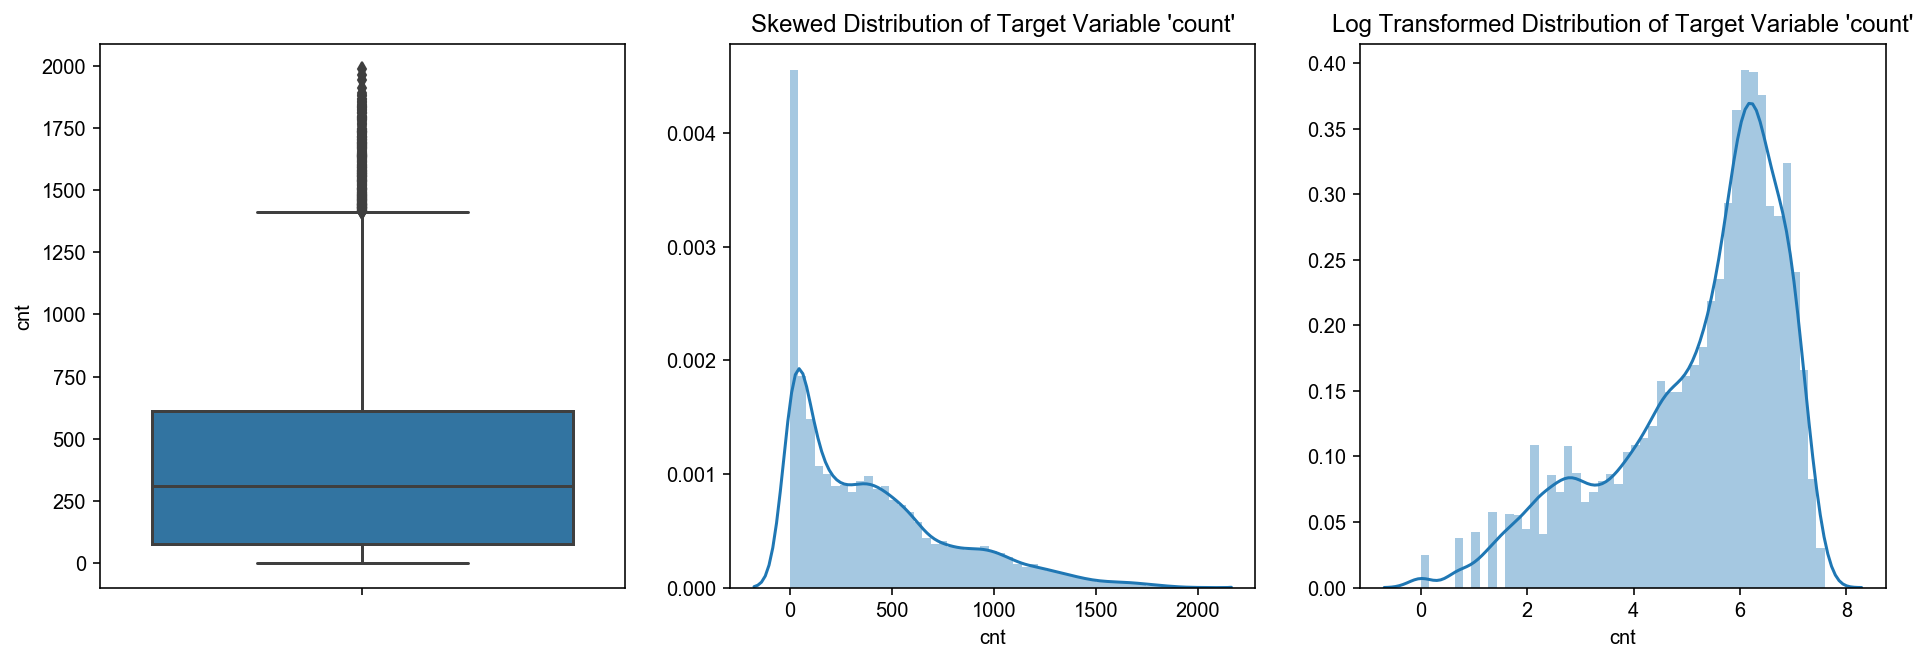

In [3]:
# Distribution of bike rental count ('cnt').
# cnt is highly right skewed, not ideal for regression. Need to perform a log transform.

fig = plt.figure(figsize=(16,5))

ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)

sns.set_style("whitegrid")
sns.boxplot(y=rides.cnt, ax=ax1)
sns.distplot(rides.cnt, ax=ax2)
sns.distplot(np.log(rides.cnt), ax=ax3)

ax2.set(title="Skewed Distribution of Target Variable 'count'")
ax3.set(title="Log Transformed Distribution of Target Variable 'count'")

fig.show()

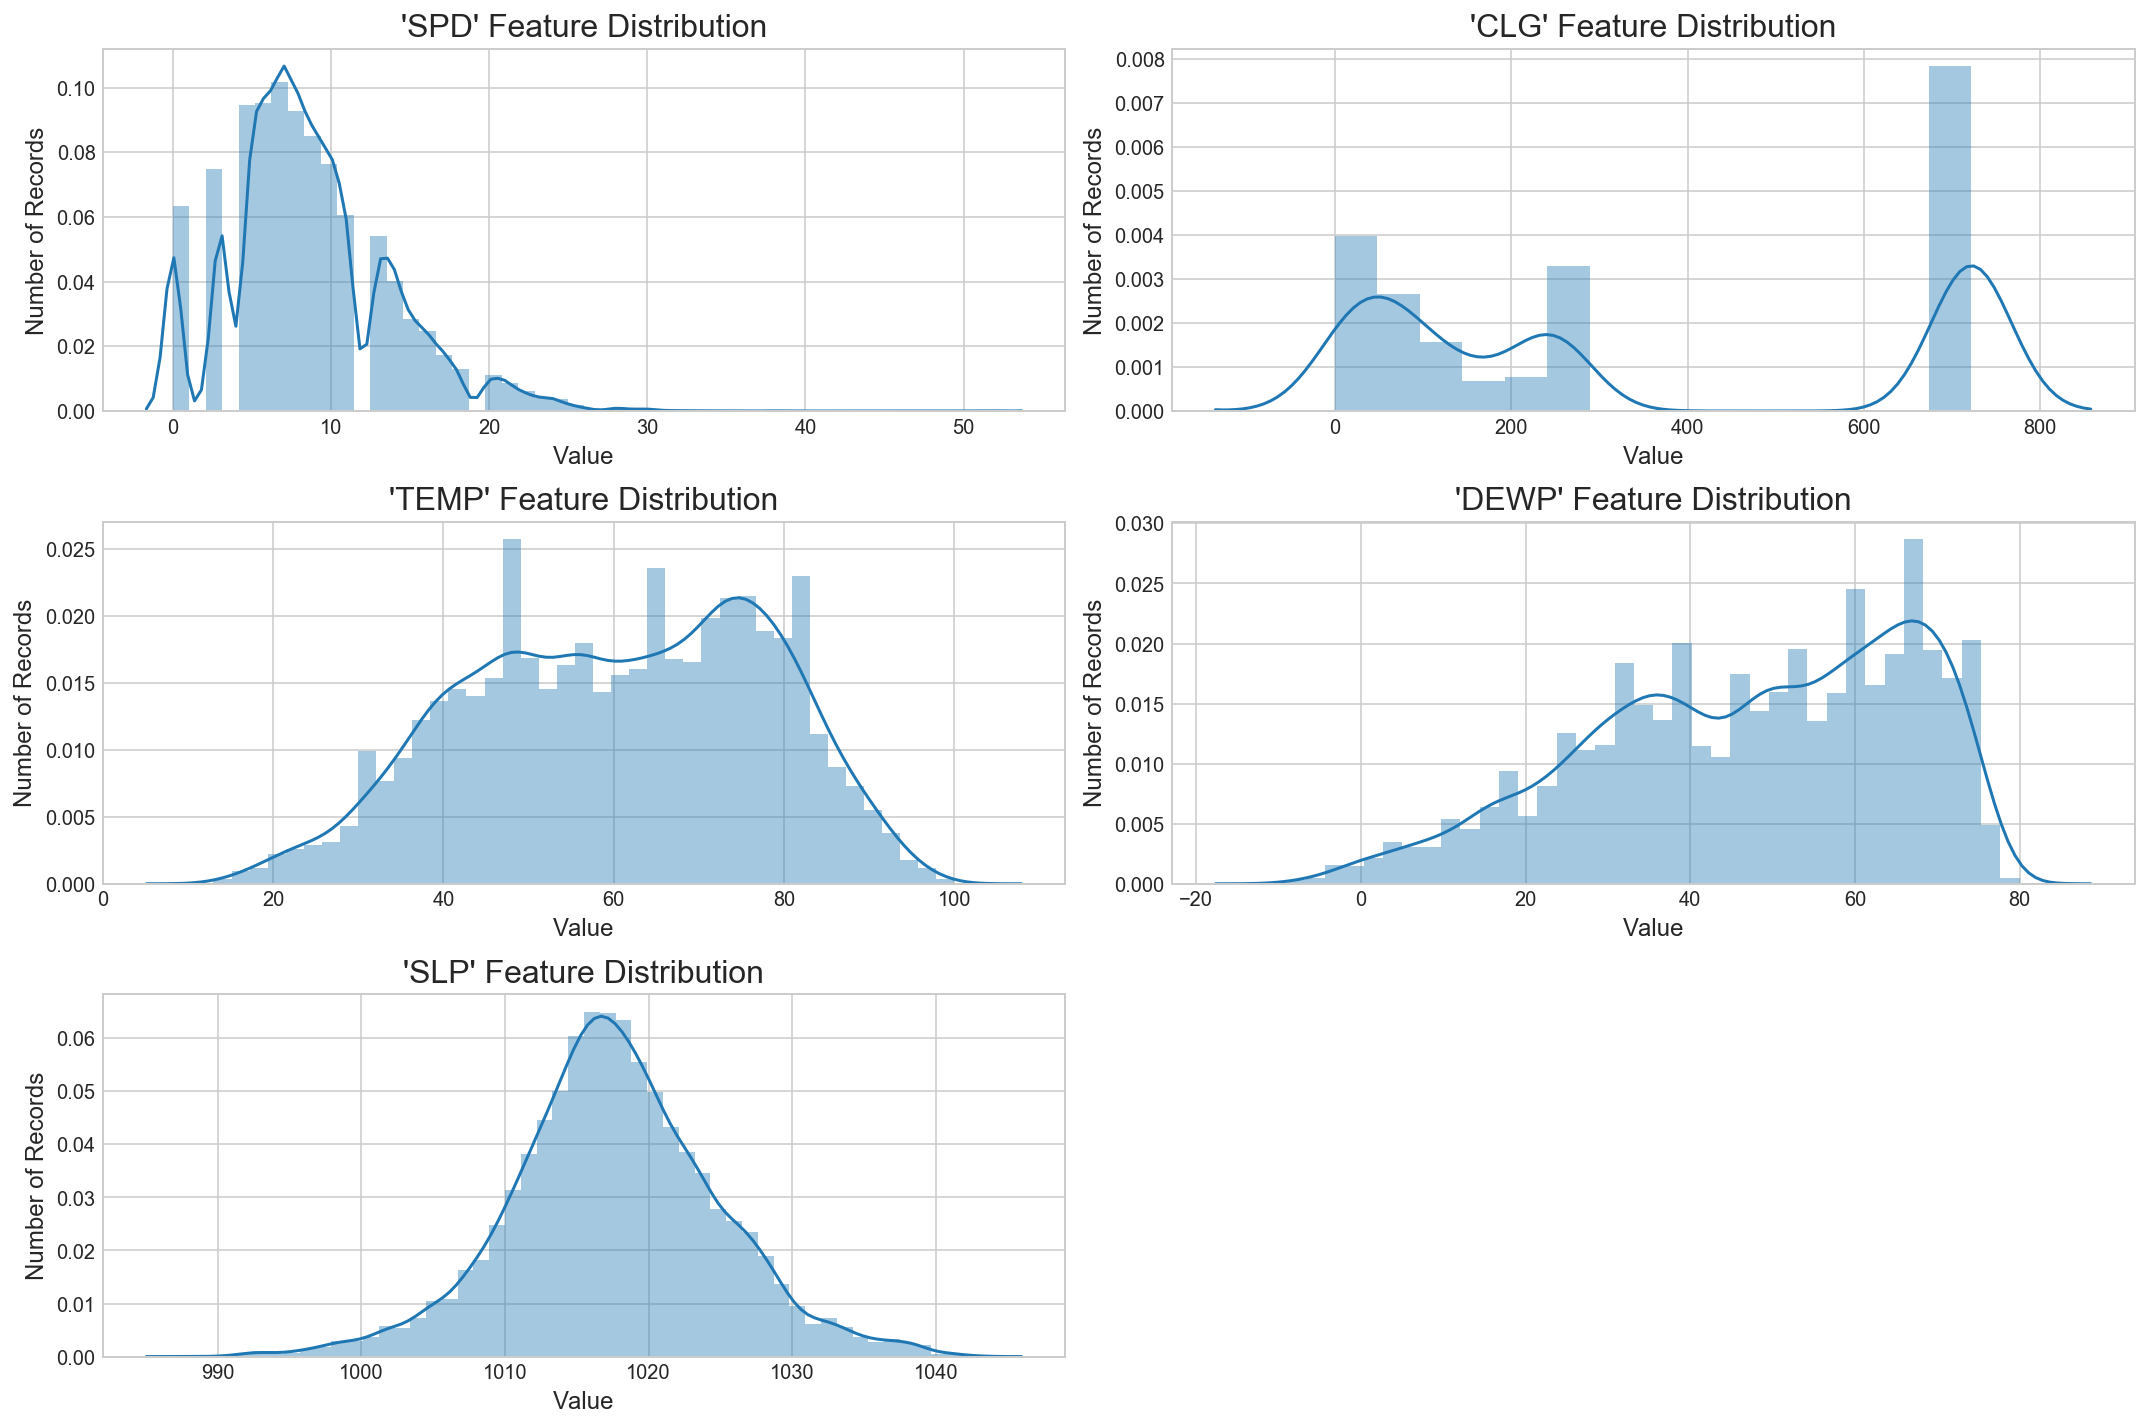

In [4]:
# Distribution of other continuous variables.
# All look OK except for 'CLG'.

fig = plt.figure(figsize = (15,10))

for i, feature in enumerate(['SPD', 'CLG', 'TEMP', 'DEWP', 'SLP']):
    ax = fig.add_subplot(3, 2, i+1)
    sns.distplot(rides[feature])
#     ax.hist(dfw[feature], bins=100, color = '#00A0A0')
    ax.set_title("'%s' Feature Distribution"%(feature), fontsize = 16)
    ax.set_xlabel("Value", fontsize = 12)
    ax.set_ylabel("Number of Records", fontsize = 12)

fig.tight_layout()
fig.show()

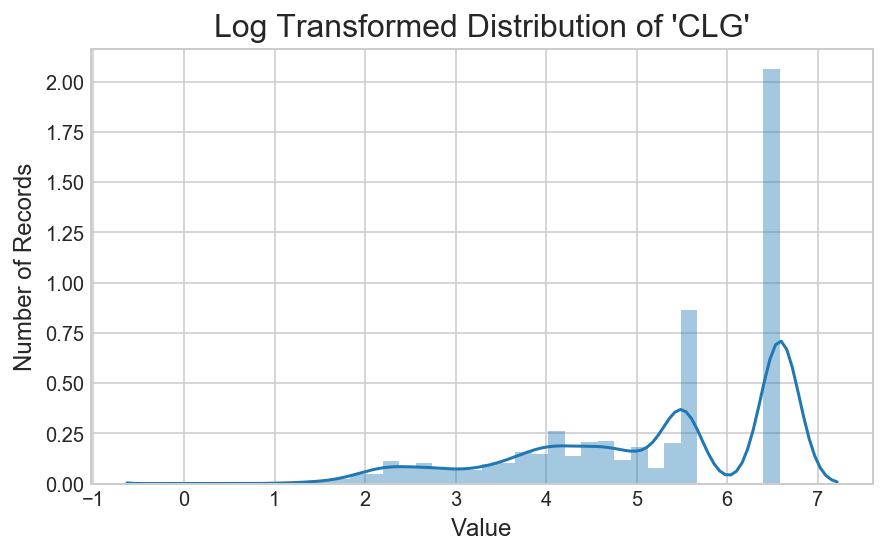

In [5]:
# Perform a log transformation on CLG.

fig = plt.figure(figsize=(7,4))
ax = sns.distplot(np.log(rides.CLG+1))
ax.set_title("Log Transformed Distribution of 'CLG'", fontsize = 16)
ax.set_xlabel("Value", fontsize = 12)
ax.set_ylabel("Number of Records", fontsize = 12)
fig.show()

### Data Exploration

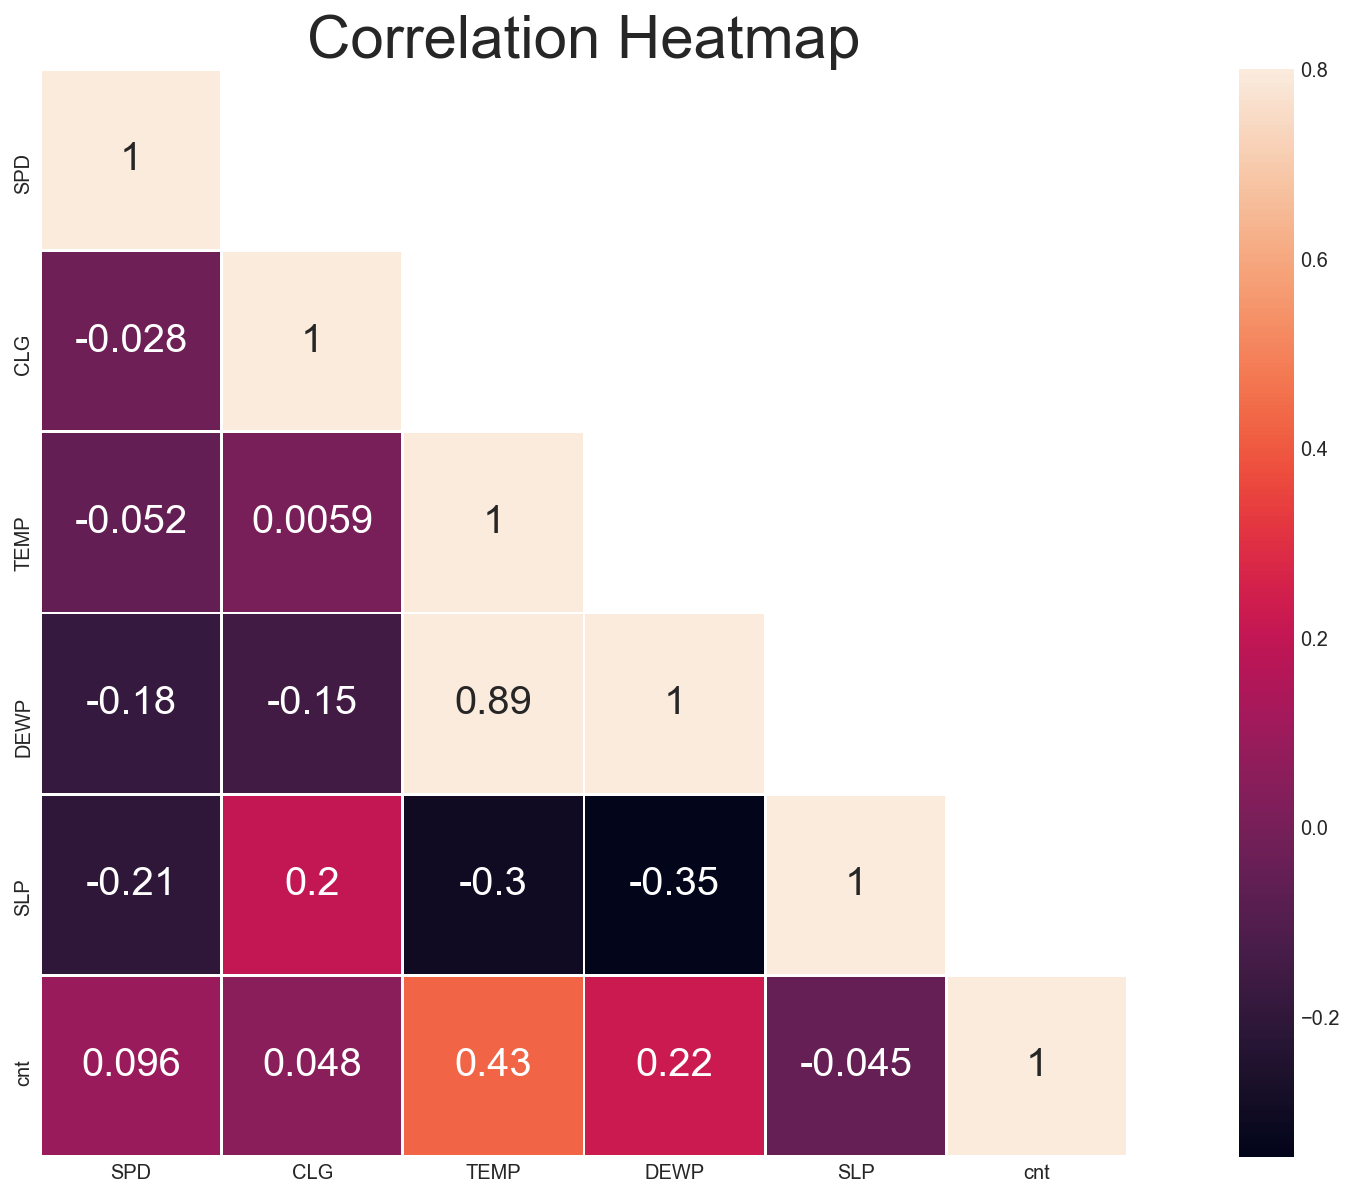

In [6]:
# Investigate the correlation between weather parameters and bike counts.

corrMatt = rides[['SPD', 'CLG', 'TEMP', 'DEWP', 'SLP','cnt']].corr()
mask = np.array(corrMatt)
mask[np.tril_indices_from(mask)] = False

fig,ax= plt.subplots()
fig.set_size_inches(20,10)

sns.heatmap(corrMatt, mask=mask,vmax=.8, square=True,annot=True,annot_kws={"size": 20}, linewidths=1)
ax.set_title('Correlation Heatmap', fontsize = 30)

fig.show()

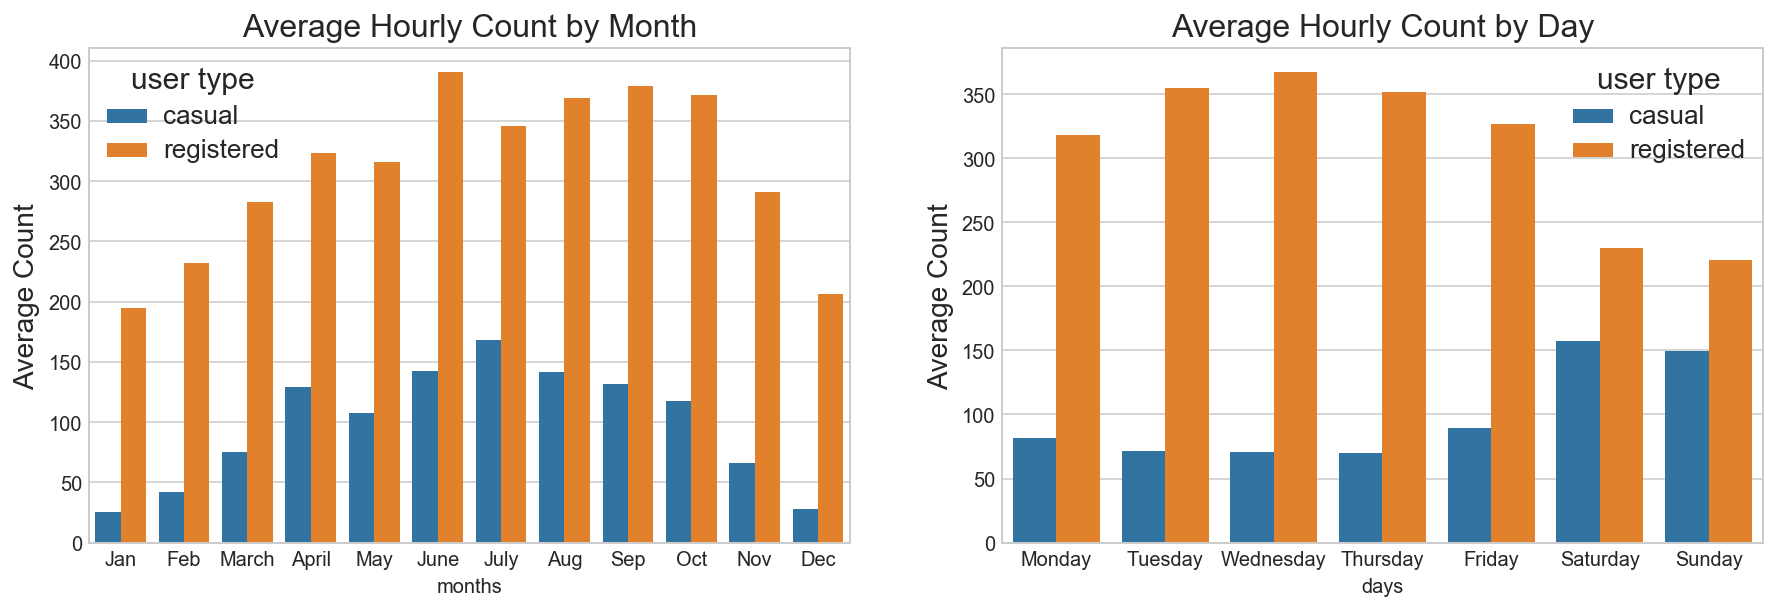

In [7]:
# Investigate the dependence of months and day of week for registered and casual users.

cnt_by_month = rides.groupby('month')['SPD', 'CLG', 'TEMP', 'DEWP', 'SLP','cnt', 'casual', 
                                                   'registered'].mean()
cnt_by_month['months'] = ["Jan","Feb","March","April","May","June","July",
                          "Aug","Sep","Oct","Nov","Dec"]
melted_byMonth = pd.melt(cnt_by_month, id_vars=['SPD', 'CLG', 'TEMP', 'DEWP', 'SLP','cnt', 'months'], 
                 var_name='user type', value_name='count')

cnt_by_day = rides.groupby('weekday')['SPD', 'CLG', 'TEMP', 'DEWP', 'SLP','cnt', 'casual', 
                                                   'registered'].mean()
cnt_by_day['days'] = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
melted_byDay = pd.melt(cnt_by_day, id_vars=['SPD', 'CLG', 'TEMP', 'DEWP', 'SLP','cnt', 'days'], 
                 var_name='user type', value_name='count')

fig = plt.figure(figsize = (15,10))
fig.add_axes()
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)

sns.barplot(x='months', y='count', hue='user type', data=melted_byMonth, ax=ax1)
sns.barplot(x='days', y='count', hue='user type', data=melted_byDay, ax=ax2)

ax1.set_title('Average Hourly Count by Month', fontsize=16)
ax1.set_ylabel('Average Count', fontsize=14)
ax2.set_title('Average Hourly Count by Day', fontsize=16)
ax2.set_ylabel('Average Count', fontsize=14)

plt.setp(ax1.get_legend().get_texts(), fontsize='13') # for legend text
plt.setp(ax1.get_legend().get_title(), fontsize='15') # for legend title

plt.setp(ax2.get_legend().get_texts(), fontsize='13') # for legend text
plt.setp(ax2.get_legend().get_title(), fontsize='15') # for legend title

fig.show()

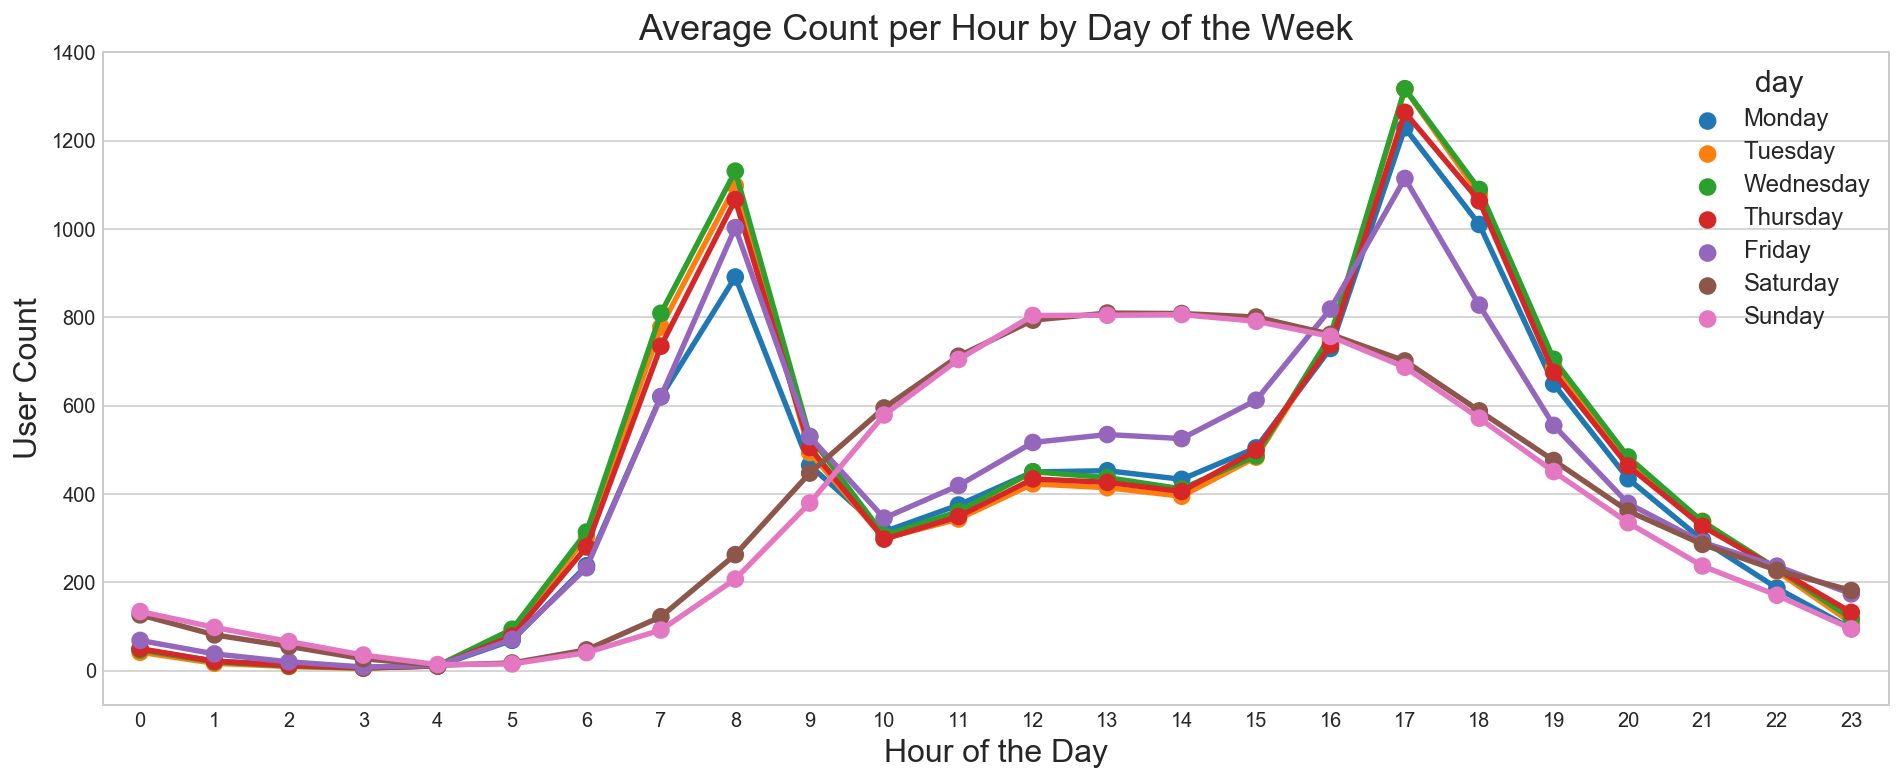

In [9]:
# Hourly bike rentals for different days of week

cnt_by_hour_weekday = pd.DataFrame(rides.groupby(['hour','weekday'])['cnt'].mean()).reset_index()
cnt_by_hour_weekday['day'] = cnt_by_hour_weekday.weekday.map({0:'Monday',1:'Tuesday',2:'Wednesday',3:'Thursday',
                                                                 4:'Friday',5:'Saturday',6:'Sunday'})

plt.figure(figsize=(16,6))

ax = sns.pointplot(x="hour", y="cnt",hue="day", data=cnt_by_hour_weekday)
ax.set_title('Average Count per Hour by Day of the Week',fontsize = 18)
ax.set_xlabel('Hour of the Day',fontsize = 16)
ax.set_ylabel('User Count',fontsize = 16)

plt.setp(ax.get_legend().get_texts(), fontsize='12') # for legend text
plt.setp(ax.get_legend().get_title(), fontsize='15') # for legend title

plt.show()

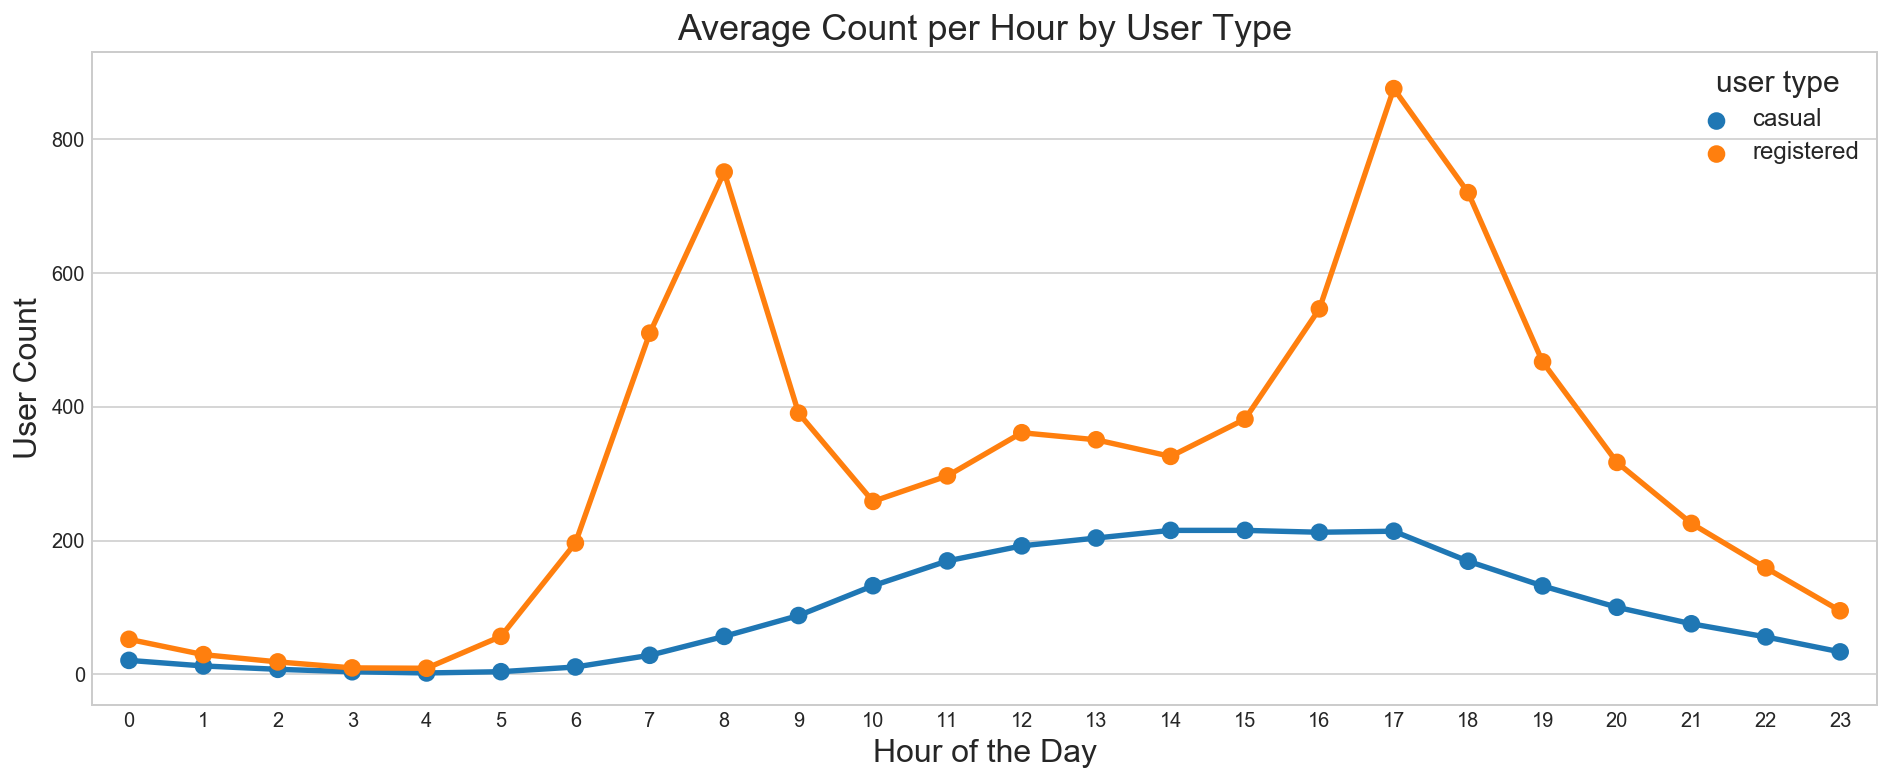

In [10]:
# 'Casual' vs. 'Registered' users for bike utilization

cnt_by_hour_user = pd.DataFrame(rides.groupby(['hour'])['casual','registered'].mean()).reset_index()
melted = pd.melt(cnt_by_hour_user, id_vars=['hour'], var_name='user type', value_name='count')

plt.figure(figsize=(16,6))

ax = sns.pointplot(x='hour', y='count',hue='user type', data=melted)
ax.set_title('Average Count per Hour by User Type',fontsize = 18)
ax.set_xlabel('Hour of the Day',fontsize = 16)
ax.set_ylabel('User Count',fontsize = 16)

plt.setp(ax.get_legend().get_texts(), fontsize='12') # for legend text
plt.setp(ax.get_legend().get_title(), fontsize='15') # for legend title

plt.show()

# Prediction using Neural Network

## Data Preprocessing


### Dummy Variables
To include categorial variables in the model, I need to make binary dummy variables (one hot encoding). 

In [11]:
rides['year'] = rides.year.apply(lambda x: 0 if x == 2016 else 1)

dummy_fields = ['quarter', 'month', 'hour', 'weekday']
for each in dummy_fields:
    dummies = pd.get_dummies(rides[each], prefix=each, drop_first=False)
    rides = pd.concat([rides, dummies], axis=1)

fields_to_drop = ['quarter', 'month', 'hour', 'weekday', 'dteday']
data = rides.drop(fields_to_drop, axis=1)
display(data.head())

,year,day,casual,registered,cnt,holiday,SPD,CLG,TEMP,DEWP,...,hour_21,hour_22,hour_23,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,0,1,9.0,47.0,56.0,1,11.0,44.0,45.0,32.0,...,0,0,0,0,0,0,0,1,0,0
1,0,1,12.0,93.0,105.0,1,8.0,46.0,44.0,32.0,...,0,0,0,0,0,0,0,1,0,0
2,0,1,15.0,59.0,74.0,1,8.0,46.0,44.0,32.0,...,0,0,0,0,0,0,0,1,0,0
3,0,1,5.0,27.0,32.0,1,8.0,220.0,42.0,32.0,...,0,0,0,0,0,0,0,1,0,0
4,0,1,5.0,8.0,13.0,1,7.0,220.0,42.0,30.0,...,0,0,0,0,0,0,0,1,0,0


### Transforming Skewed Continuous Variables
As shown above, 'cnt' and 'CLG' are highly skewed and need a log transformation to reduce the negative impact caused by outliers.

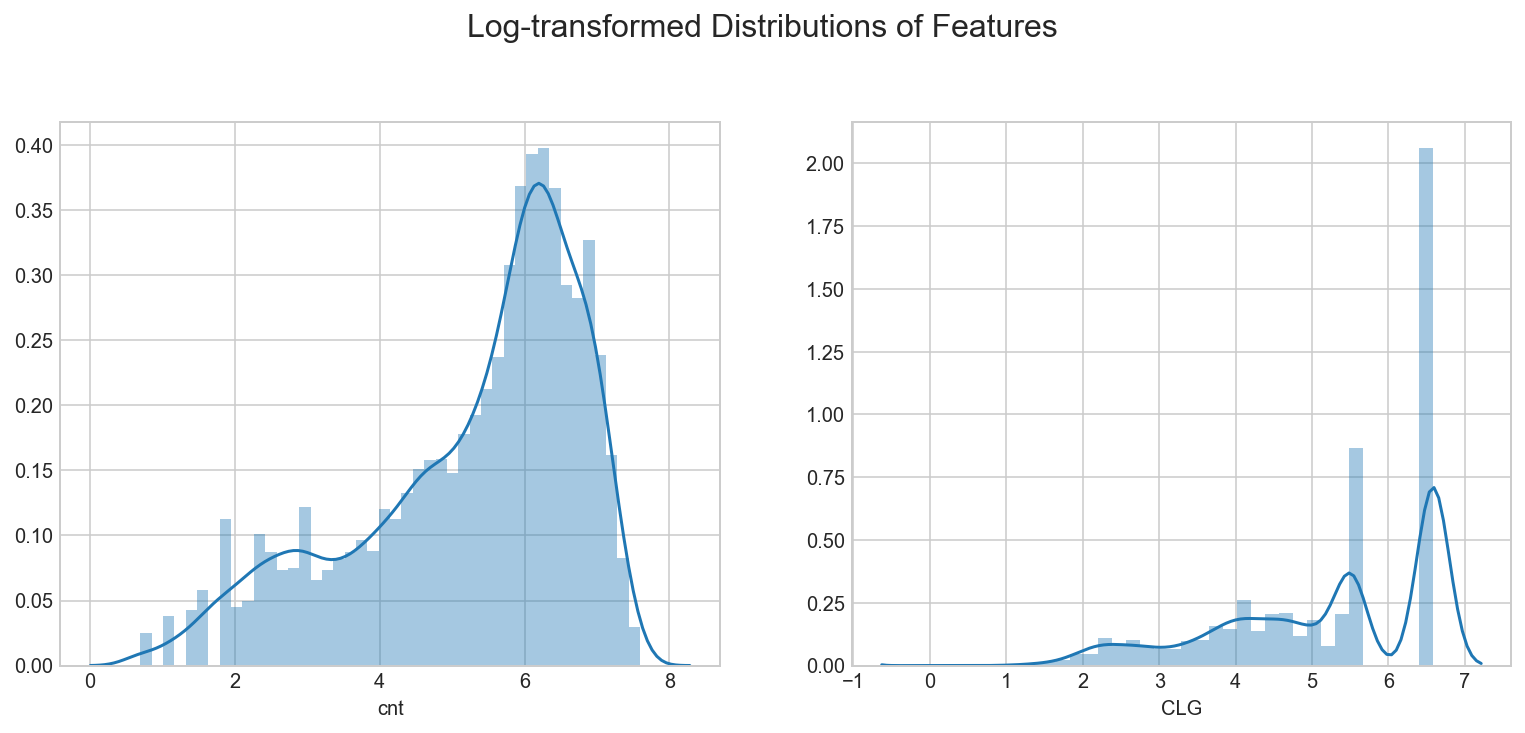

In [12]:
pd.options.mode.chained_assignment = None  # default='warn'

# Log-transform the skewed features
skewed = ['cnt','CLG']
data[skewed] = data[skewed].apply(lambda x: np.log(x + 1))

fig = plt.figure(figsize=(13,5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

sns.distplot(data.cnt, ax=ax1)
sns.distplot(data.CLG, ax=ax2)

fig.suptitle('Log-transformed Distributions of Features', fontsize = 16, y = 1.03)

fig.show()

### Feature Scaling
Standardize continuous variables such that they all have zero means and standard deviation of 1. Normalization ensures that each feature is treated equally in machine learning.

In [13]:
pd.options.mode.chained_assignment = None  # default='warn'

quant_features = ['casual', 'registered', 'cnt', 'SPD', 'CLG', 'TEMP', 'DEWP', 'SLP']

# Perform feature scaling such that all features ranging between have zero mean and a standard deviation of 1.. 
scaled_features = {}
for each in quant_features:
    mean, std = data[each].mean(), data[each].std()
    scaled_features[each] = [mean, std]
    data.loc[:, each] = (data[each] - mean)/std

### Data Splitting Into Training, Testing & Validation Sets

I save the data for the last month (December, 31 days) to use as a test set after training the network. I'll use this set to make predictions and compare them with the actual number of riders.

In [14]:
# Save data for approximately the last 31 days 
test_data = data[-31*24:]

# Remove the test data from the orginial data set 
data = data[:-31*24]

# Separate the data into features and targets
target_fields = ['cnt', 'casual', 'registered']
features, targets = data.drop(target_fields, axis=1), data[target_fields]
test_features, test_targets = test_data.drop(target_fields, axis=1), test_data[target_fields]

In [15]:
# Hold out the last 60 days or so of the remaining data as a validation set
train_features, train_targets = features[:-60*24], targets[:-60*24]
val_features, val_targets = features[-60*24:], targets[-60*24:]

## Neural Network Model

In [16]:
# Set train, test and validation datasets
X_train = np.array(train_features)
y_train = np.array(train_targets['cnt'])
X_val = np.array(val_features)
y_val = np.array(val_targets['cnt'])
X_test = np.array(test_features)
y_test = np.array(test_targets['cnt'])

print(X_train.shape)
print(y_train.shape)

(15184, 55)
(15184,)


In [17]:
# Build neural network using keras. Vary learning rates, optimizers.
# There are three layers in neural network model.

model1 = Sequential()

model1.add(Dense(20, input_dim=train_features.shape[1]))
model1.add(Activation('sigmoid'))
model1.add(Dense(1))

# comapred with default lr=0.001, the curve is more fluctuated and the error is larger.
adam = optimizers.Adam(lr=0.01)
model1.compile(loss='mse', optimizer = adam, metrics = ['mse'])
history1 = model1.fit(X_train, y_train, epochs=100, 
                    validation_data=(X_val,y_val), batch_size=X_train.shape[1], verbose=2)

Train on 15184 samples, validate on 1440 samples
Epoch 1/100
 - 1s - loss: 0.2667 - mean_squared_error: 0.2667 - val_loss: 0.1568 - val_mean_squared_error: 0.1568
Epoch 2/100
 - 0s - loss: 0.1330 - mean_squared_error: 0.1330 - val_loss: 0.1077 - val_mean_squared_error: 0.1077
Epoch 3/100
 - 0s - loss: 0.0852 - mean_squared_error: 0.0852 - val_loss: 0.0694 - val_mean_squared_error: 0.0694
Epoch 4/100
 - 0s - loss: 0.0624 - mean_squared_error: 0.0624 - val_loss: 0.0560 - val_mean_squared_error: 0.0560
Epoch 5/100
 - 0s - loss: 0.0569 - mean_squared_error: 0.0569 - val_loss: 0.0551 - val_mean_squared_error: 0.0551
Epoch 6/100
 - 0s - loss: 0.0544 - mean_squared_error: 0.0544 - val_loss: 0.0518 - val_mean_squared_error: 0.0518
Epoch 7/100
 - 0s - loss: 0.0518 - mean_squared_error: 0.0518 - val_loss: 0.0700 - val_mean_squared_error: 0.0700
Epoch 8/100
 - 0s - loss: 0.0517 - mean_squared_error: 0.0517 - val_loss: 0.0439 - val_mean_squared_error: 0.0439
Epoch 9/100
 - 0s - loss: 0.0494 - mean

Epoch 72/100
 - 0s - loss: 0.0387 - mean_squared_error: 0.0387 - val_loss: 0.0533 - val_mean_squared_error: 0.0533
Epoch 73/100
 - 0s - loss: 0.0368 - mean_squared_error: 0.0368 - val_loss: 0.0507 - val_mean_squared_error: 0.0507
Epoch 74/100
 - 0s - loss: 0.0375 - mean_squared_error: 0.0375 - val_loss: 0.0503 - val_mean_squared_error: 0.0503
Epoch 75/100
 - 0s - loss: 0.0374 - mean_squared_error: 0.0374 - val_loss: 0.0548 - val_mean_squared_error: 0.0548
Epoch 76/100
 - 0s - loss: 0.0373 - mean_squared_error: 0.0373 - val_loss: 0.0504 - val_mean_squared_error: 0.0504
Epoch 77/100
 - 0s - loss: 0.0375 - mean_squared_error: 0.0375 - val_loss: 0.0471 - val_mean_squared_error: 0.0471
Epoch 78/100
 - 0s - loss: 0.0373 - mean_squared_error: 0.0373 - val_loss: 0.0494 - val_mean_squared_error: 0.0494
Epoch 79/100
 - 0s - loss: 0.0368 - mean_squared_error: 0.0368 - val_loss: 0.0524 - val_mean_squared_error: 0.0524
Epoch 80/100
 - 0s - loss: 0.0372 - mean_squared_error: 0.0372 - val_loss: 0.051

In [18]:
model2 = Sequential()

model2.add(Dense(20, input_dim=train_features.shape[1]))
model2.add(Activation('sigmoid'))
model2.add(Dense(1))

## much worse than 'adam', default learning rate is 0.01
model2.compile(loss='mse', optimizer = 'sgd', metrics = ['mse'])
history2 = model2.fit(X_train, y_train, epochs=100, 
                    validation_data=(X_val,y_val), batch_size=X_train.shape[1], verbose=2)

Train on 15184 samples, validate on 1440 samples
Epoch 1/100
 - 0s - loss: 0.9311 - mean_squared_error: 0.9311 - val_loss: 0.9226 - val_mean_squared_error: 0.9226
Epoch 2/100
 - 0s - loss: 0.8471 - mean_squared_error: 0.8471 - val_loss: 0.7947 - val_mean_squared_error: 0.7947
Epoch 3/100
 - 0s - loss: 0.7886 - mean_squared_error: 0.7886 - val_loss: 0.7765 - val_mean_squared_error: 0.7765
Epoch 4/100
 - 0s - loss: 0.7336 - mean_squared_error: 0.7336 - val_loss: 0.7490 - val_mean_squared_error: 0.7490
Epoch 5/100
 - 0s - loss: 0.6735 - mean_squared_error: 0.6735 - val_loss: 1.4257 - val_mean_squared_error: 1.4257
Epoch 6/100
 - 0s - loss: 0.6263 - mean_squared_error: 0.6263 - val_loss: 1.1914 - val_mean_squared_error: 1.1914
Epoch 7/100
 - 0s - loss: 0.5569 - mean_squared_error: 0.5569 - val_loss: 0.4849 - val_mean_squared_error: 0.4849
Epoch 8/100
 - 0s - loss: 0.5396 - mean_squared_error: 0.5396 - val_loss: 0.4138 - val_mean_squared_error: 0.4138
Epoch 9/100
 - 0s - loss: 0.5046 - mean

Epoch 72/100
 - 0s - loss: 0.1670 - mean_squared_error: 0.1670 - val_loss: 0.2247 - val_mean_squared_error: 0.2247
Epoch 73/100
 - 0s - loss: 0.1703 - mean_squared_error: 0.1703 - val_loss: 0.5964 - val_mean_squared_error: 0.5964
Epoch 74/100
 - 0s - loss: 0.1653 - mean_squared_error: 0.1653 - val_loss: 0.1457 - val_mean_squared_error: 0.1457
Epoch 75/100
 - 0s - loss: 0.1660 - mean_squared_error: 0.1660 - val_loss: 0.1571 - val_mean_squared_error: 0.1571
Epoch 76/100
 - 0s - loss: 0.1662 - mean_squared_error: 0.1662 - val_loss: 0.2146 - val_mean_squared_error: 0.2146
Epoch 77/100
 - 0s - loss: 0.1619 - mean_squared_error: 0.1619 - val_loss: 0.2317 - val_mean_squared_error: 0.2317
Epoch 78/100
 - 0s - loss: 0.1631 - mean_squared_error: 0.1631 - val_loss: 0.1713 - val_mean_squared_error: 0.1713
Epoch 79/100
 - 0s - loss: 0.1577 - mean_squared_error: 0.1577 - val_loss: 0.5548 - val_mean_squared_error: 0.5548
Epoch 80/100
 - 0s - loss: 0.1598 - mean_squared_error: 0.1598 - val_loss: 0.172

In [19]:
model3 = Sequential()

model3.add(Dense(20, input_dim=train_features.shape[1]))
model3.add(Activation('sigmoid'))
model3.add(Dense(1))

# the curve becomes smoother when decreasing lr
sgd = optimizers.SGD(lr=0.001)
model3.compile(loss='mse', optimizer = sgd, metrics = ['mse'])

history3 = model3.fit(X_train, y_train, epochs=100, 
                    validation_data=(X_val,y_val), batch_size=X_train.shape[1], verbose=2)

Train on 15184 samples, validate on 1440 samples
Epoch 1/100
 - 0s - loss: 1.0368 - mean_squared_error: 1.0368 - val_loss: 0.9199 - val_mean_squared_error: 0.9199
Epoch 2/100
 - 0s - loss: 0.9693 - mean_squared_error: 0.9693 - val_loss: 0.8868 - val_mean_squared_error: 0.8868
Epoch 3/100
 - 0s - loss: 0.9161 - mean_squared_error: 0.9161 - val_loss: 0.8542 - val_mean_squared_error: 0.8542
Epoch 4/100
 - 0s - loss: 0.8675 - mean_squared_error: 0.8675 - val_loss: 0.8205 - val_mean_squared_error: 0.8205
Epoch 5/100
 - 0s - loss: 0.8247 - mean_squared_error: 0.8247 - val_loss: 0.7956 - val_mean_squared_error: 0.7956
Epoch 6/100
 - 0s - loss: 0.7851 - mean_squared_error: 0.7851 - val_loss: 0.7527 - val_mean_squared_error: 0.7527
Epoch 7/100
 - 0s - loss: 0.7500 - mean_squared_error: 0.7500 - val_loss: 0.7809 - val_mean_squared_error: 0.7809
Epoch 8/100
 - 0s - loss: 0.7148 - mean_squared_error: 0.7148 - val_loss: 0.7548 - val_mean_squared_error: 0.7548
Epoch 9/100
 - 0s - loss: 0.6798 - mean

Epoch 72/100
 - 0s - loss: 0.1684 - mean_squared_error: 0.1684 - val_loss: 0.1782 - val_mean_squared_error: 0.1782
Epoch 73/100
 - 0s - loss: 0.1691 - mean_squared_error: 0.1691 - val_loss: 0.2012 - val_mean_squared_error: 0.2012
Epoch 74/100
 - 0s - loss: 0.1734 - mean_squared_error: 0.1734 - val_loss: 0.1658 - val_mean_squared_error: 0.1658
Epoch 75/100
 - 0s - loss: 0.1659 - mean_squared_error: 0.1659 - val_loss: 0.2085 - val_mean_squared_error: 0.2085
Epoch 76/100
 - 0s - loss: 0.1651 - mean_squared_error: 0.1651 - val_loss: 0.8184 - val_mean_squared_error: 0.8184
Epoch 77/100
 - 0s - loss: 0.1654 - mean_squared_error: 0.1654 - val_loss: 0.2067 - val_mean_squared_error: 0.2067
Epoch 78/100
 - 0s - loss: 0.1728 - mean_squared_error: 0.1728 - val_loss: 0.1488 - val_mean_squared_error: 0.1488
Epoch 79/100
 - 0s - loss: 0.1676 - mean_squared_error: 0.1676 - val_loss: 0.5418 - val_mean_squared_error: 0.5418
Epoch 80/100
 - 0s - loss: 0.1602 - mean_squared_error: 0.1602 - val_loss: 0.428

In [20]:
model = Sequential()

model.add(Dense(20, input_dim=train_features.shape[1]))
model.add(Activation('sigmoid'))
model.add(Dense(1))

model.compile(loss='mse', optimizer = 'adam', metrics = ['mse'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 20)                1120      
_________________________________________________________________
activation_4 (Activation)    (None, 20)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 21        
Total params: 1,141
Trainable params: 1,141
Non-trainable params: 0
_________________________________________________________________


In [21]:
history = model.fit(X_train, y_train, epochs=100, 
                    validation_data=(X_val,y_val), batch_size=X_train.shape[1], verbose=2)


Train on 15184 samples, validate on 1440 samples
Epoch 1/100
 - 1s - loss: 0.8396 - mean_squared_error: 0.8396 - val_loss: 0.6077 - val_mean_squared_error: 0.6077
Epoch 2/100
 - 0s - loss: 0.3802 - mean_squared_error: 0.3802 - val_loss: 0.2016 - val_mean_squared_error: 0.2016
Epoch 3/100
 - 0s - loss: 0.1771 - mean_squared_error: 0.1771 - val_loss: 0.1504 - val_mean_squared_error: 0.1504
Epoch 4/100
 - 0s - loss: 0.1550 - mean_squared_error: 0.1550 - val_loss: 0.1476 - val_mean_squared_error: 0.1476
Epoch 5/100
 - 0s - loss: 0.1518 - mean_squared_error: 0.1518 - val_loss: 0.1468 - val_mean_squared_error: 0.1468
Epoch 6/100
 - 0s - loss: 0.1503 - mean_squared_error: 0.1503 - val_loss: 0.1470 - val_mean_squared_error: 0.1470
Epoch 7/100
 - 0s - loss: 0.1500 - mean_squared_error: 0.1500 - val_loss: 0.1455 - val_mean_squared_error: 0.1455
Epoch 8/100
 - 0s - loss: 0.1487 - mean_squared_error: 0.1487 - val_loss: 0.1479 - val_mean_squared_error: 0.1479
Epoch 9/100
 - 0s - loss: 0.1476 - mean

Epoch 72/100
 - 0s - loss: 0.0420 - mean_squared_error: 0.0420 - val_loss: 0.0448 - val_mean_squared_error: 0.0448
Epoch 73/100
 - 0s - loss: 0.0419 - mean_squared_error: 0.0419 - val_loss: 0.0443 - val_mean_squared_error: 0.0443
Epoch 74/100
 - 0s - loss: 0.0417 - mean_squared_error: 0.0417 - val_loss: 0.0431 - val_mean_squared_error: 0.0431
Epoch 75/100
 - 0s - loss: 0.0416 - mean_squared_error: 0.0416 - val_loss: 0.0477 - val_mean_squared_error: 0.0477
Epoch 76/100
 - 0s - loss: 0.0417 - mean_squared_error: 0.0417 - val_loss: 0.0505 - val_mean_squared_error: 0.0505
Epoch 77/100
 - 0s - loss: 0.0415 - mean_squared_error: 0.0415 - val_loss: 0.0420 - val_mean_squared_error: 0.0420
Epoch 78/100
 - 0s - loss: 0.0411 - mean_squared_error: 0.0411 - val_loss: 0.0429 - val_mean_squared_error: 0.0429
Epoch 79/100
 - 0s - loss: 0.0412 - mean_squared_error: 0.0412 - val_loss: 0.0427 - val_mean_squared_error: 0.0427
Epoch 80/100
 - 0s - loss: 0.0410 - mean_squared_error: 0.0410 - val_loss: 0.046

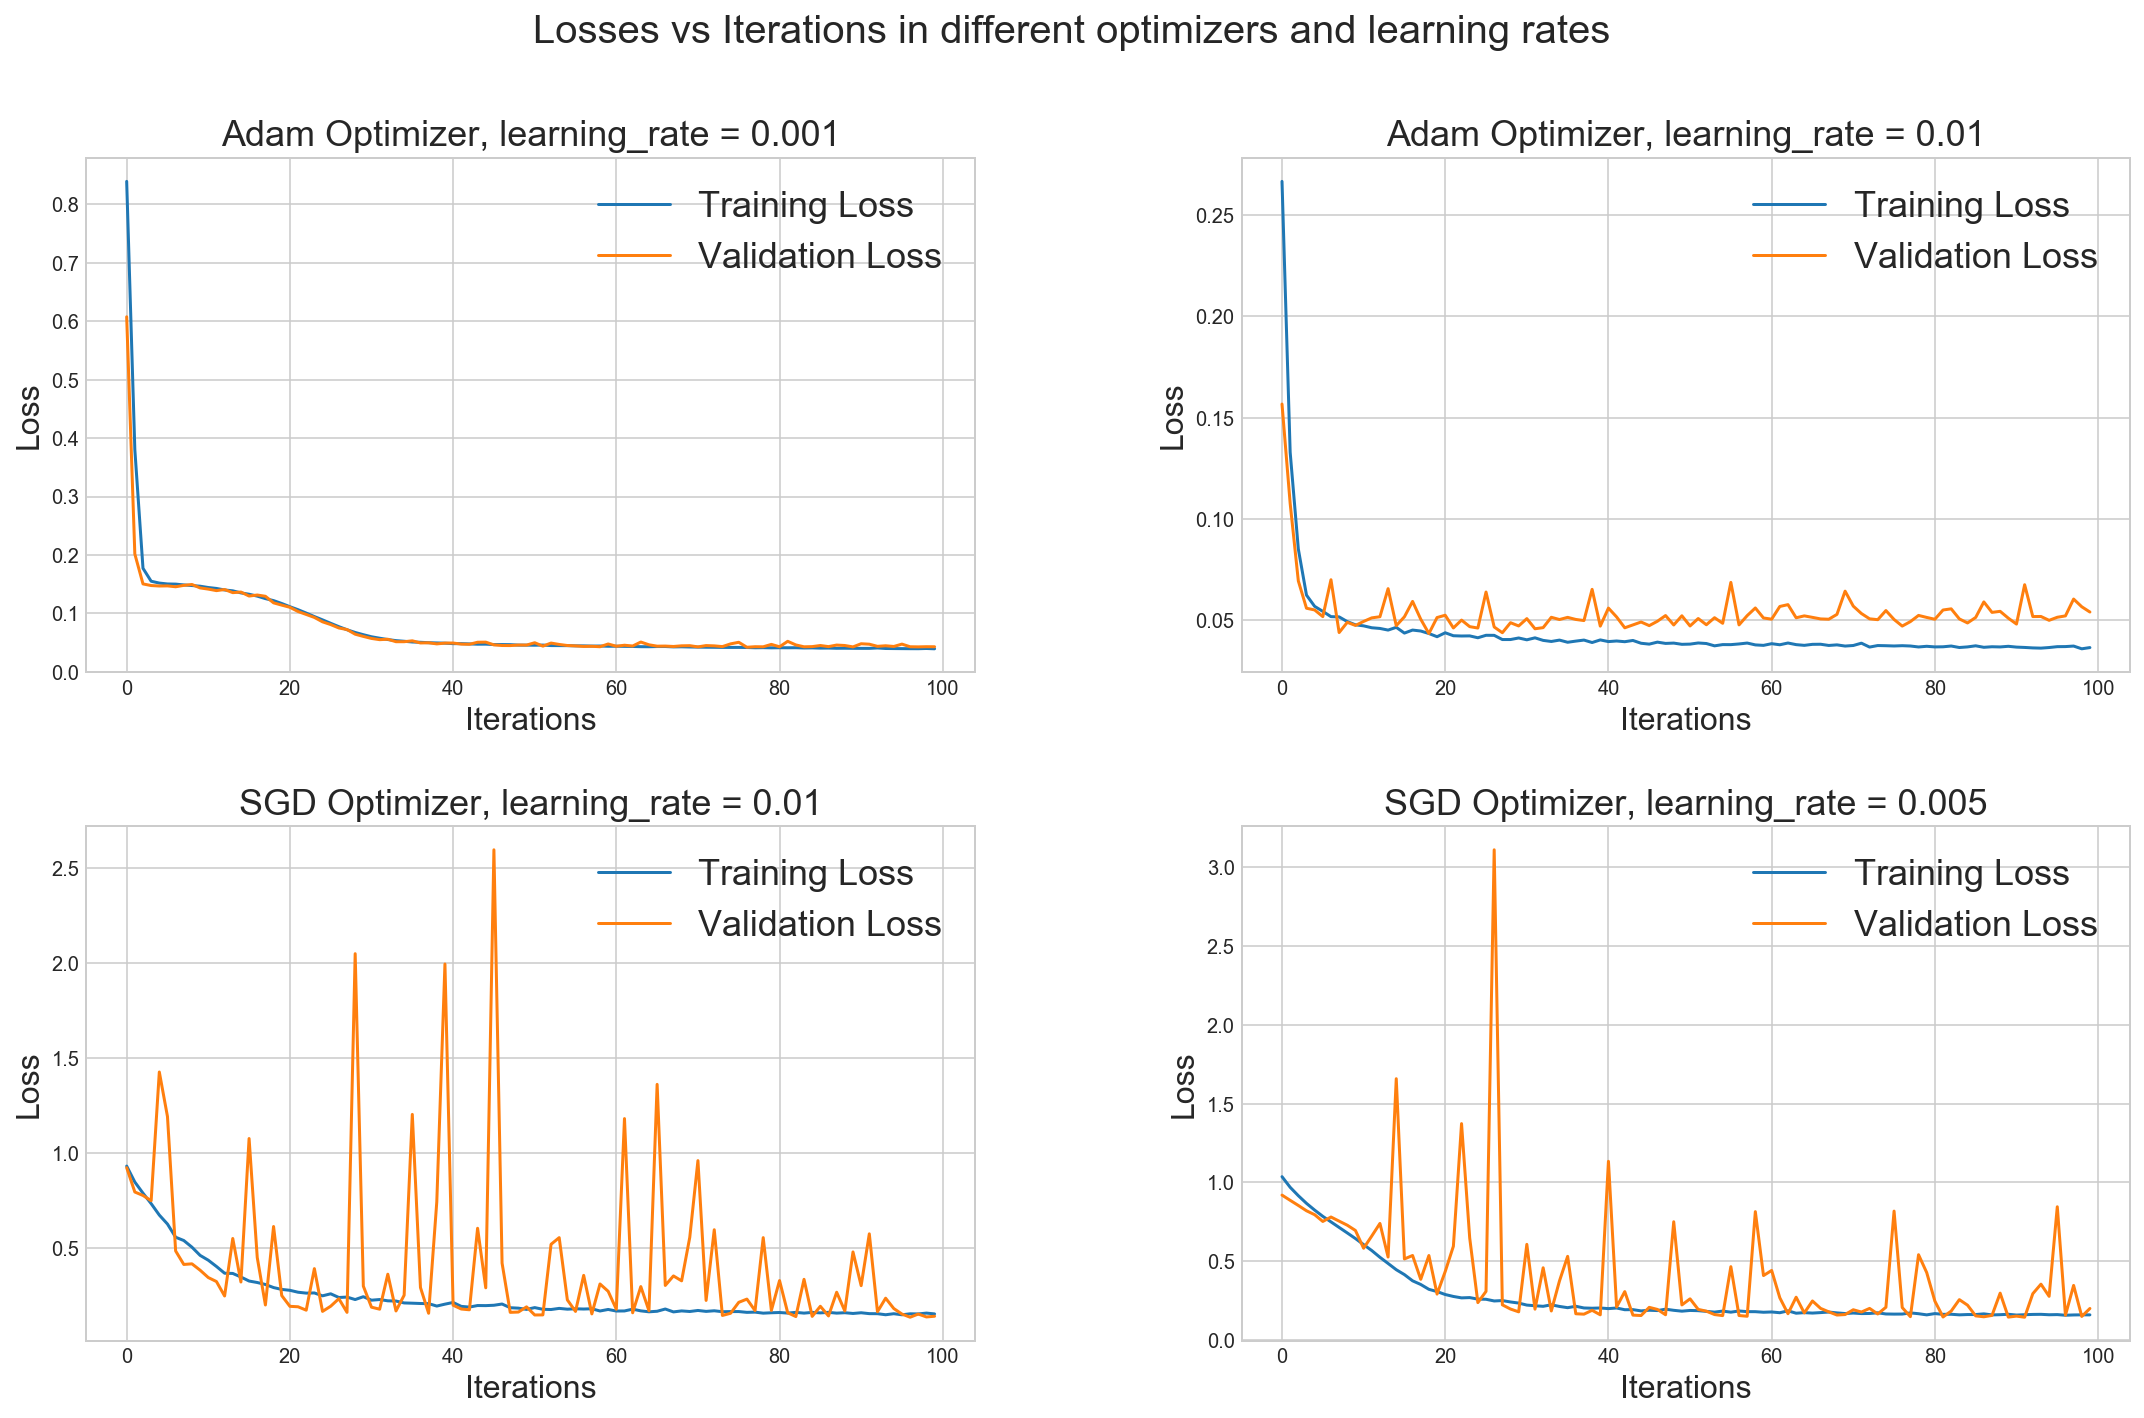

In [22]:
fig = plt.figure(figsize = (15,10))
fig.suptitle('Losses vs Iterations in different optimizers and learning rates', fontsize = 20)

ax1 = fig.add_subplot(221)
ax1.plot(history.history['mean_squared_error'], label='Training Loss')
ax1.plot(history.history['val_mean_squared_error'], label='Validation Loss')
ax1.legend(fontsize = 18)
ax1.set_title('Adam Optimizer, learning_rate = 0.001', fontsize = 18)
ax1.set_xlabel('Iterations', fontsize = 16)
ax1.set_ylabel('Loss', fontsize =16)

ax2 = fig.add_subplot(222)
ax2.plot(history1.history['mean_squared_error'], label='Training Loss')
ax2.plot(history1.history['val_mean_squared_error'], label='Validation Loss')
ax2.legend(fontsize = 18)
ax2.set_title('Adam Optimizer, learning_rate = 0.01', fontsize = 18)
ax2.set_xlabel('Iterations', fontsize = 16)
ax2.set_ylabel('Loss', fontsize =16)

ax3 = fig.add_subplot(223)
ax3.plot(history2.history['mean_squared_error'], label='Training Loss')
ax3.plot(history2.history['val_mean_squared_error'], label='Validation Loss')
ax3.legend(fontsize = 18)
ax3.set_title('SGD Optimizer, learning_rate = 0.01', fontsize = 18)
ax3.set_xlabel('Iterations', fontsize = 16)
ax3.set_ylabel('Loss', fontsize =16)

ax4 = fig.add_subplot(224)
ax4.plot(history3.history['mean_squared_error'], label='Training Loss')
ax4.plot(history3.history['val_mean_squared_error'], label='Validation Loss')
ax4.legend(fontsize = 18)
ax4.set_title('SGD Optimizer, learning_rate = 0.001', fontsize = 18)
ax4.set_xlabel('Iterations', fontsize = 16)
ax4.set_ylabel('Loss', fontsize =16)

fig.tight_layout()
plt.subplots_adjust(wspace = 0.3, hspace = 0.3)
fig.subplots_adjust(top=0.88)

In [23]:
mean, std = scaled_features['cnt']
predictions = np.exp(model.predict(X_test).T*std + mean)
print(predictions[0].shape)

(744,)


C:\Users\cz043d\AppData\Local\Continuum\anaconda2\envs\keras1\lib\site-packages\ipykernel_launcher.py:11: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  # This is added back by InteractiveShellApp.init_path()


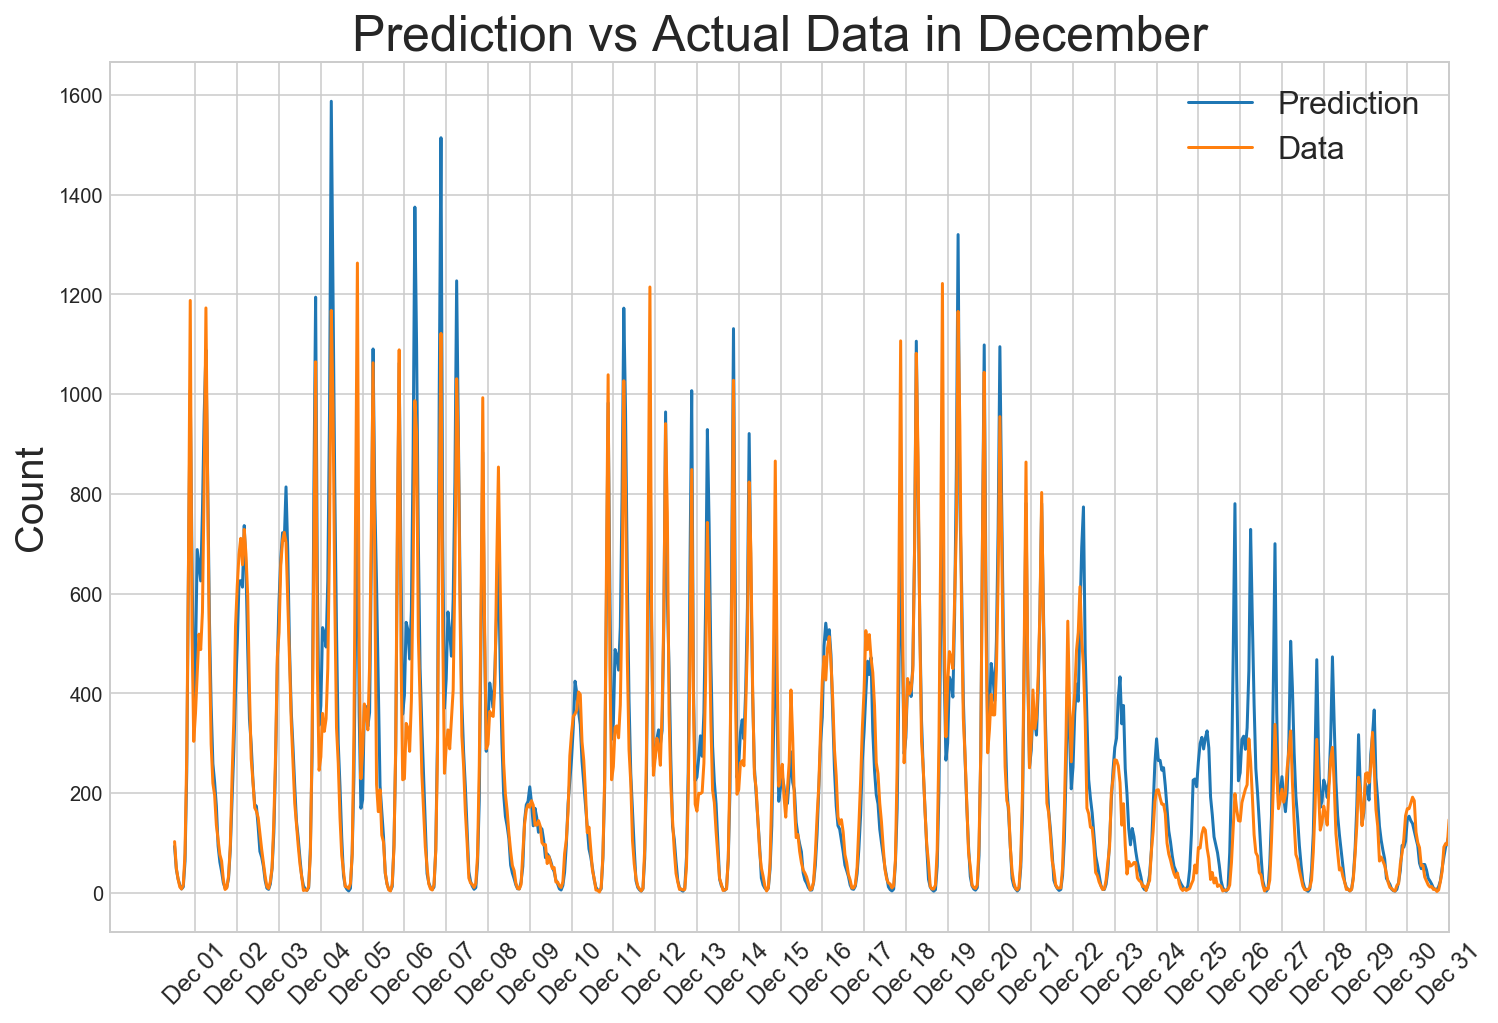

In [24]:
fig, ax = plt.subplots(figsize=(12,8))

ax.plot(predictions[0], label='Prediction')
ax.plot(np.exp((test_targets['cnt']*std + mean).values), label='Data')
ax.set_xlim(right=len(predictions))
ax.legend(fontsize = 16)

plt.ylabel('Count', fontsize = 20)
plt.title('Prediction vs Actual Data in December', fontsize = 25)

dates = pd.to_datetime(rides.ix[test_data.index]['dteday'])
dates = dates.apply(lambda d: d.strftime('%b %d'))
ax.set_xticks(np.arange(len(dates))[12::24])
_ = ax.set_xticklabels(dates[12::24], rotation=45, fontsize=12)

In [25]:
def MSE(y, Y):
    return np.mean((y-Y)**2)

test_loss = MSE(model.predict(X_test).T, test_targets['cnt'].values)
print('Test loss of cnt: ', test_loss)

Test loss of cnt:  0.0762689290679
